In [2]:
%pwd

'/Users/avinashmacbookair/mcvae/src/experiments'

In [11]:
import torch
import torchvision 
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
from tqdm import tqdm
from sklearn.manifold import TSNE
import seaborn as sns
sys.path.append('/Users/avinashmacbookair/mcvae')
from src.mcvae.datasets import SyntheticDataset
from src.mcvae.models import Mcvae,VAE
from src.mcvae.utilities import preprocess_and_add_noise, simulate_mar_multi_channel_data
from src.mcvae.models.utils import DEVICE, load_or_fit, model_press

In [12]:
def rotate_mnist(tensor, angle):
    # Reshape the 1D tensor to a 2D array 
    image = np.array(tensor).reshape((10, 1))

    # Specify the center of rotation 
    center = (1, 2)

    # Perform the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (10, 1))

    return rotated_image.tolist()

# Usage:
synthetic_dataset = SyntheticDataset(n=100, lat_dim=2, n_feats=5, n_channels=2, train=True)
all_data = list(synthetic_dataset)

# Specify a list of angles
angles = [0, 45, 90, 135]

# Rotate all digits in the list of 1D tensors for each angle
rotated_data = {angle: [rotate_mnist(tensor, angle) for tensor in all_data] for angle in angles}

# Print the rotated_data
for angle, data in rotated_data.items():
    print(f"Rotated Data for Angle {angle}:\n")
    for i, tensor in enumerate(data):
        print(f"Rotated Digit {i + 1}:\n{np.array(tensor)}\n")

Rotated Data for Angle 0:

Rotated Digit 1:
[[0.10307349 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]

Rotated Digit 2:
[[0.16056052 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]

Rotated Digit 3:
[[-0.13008158  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]

Rotated Digit 4:
[[-0.66806281  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]

Rotated Digit 5:
[[0.39738339 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]

Rotated Digit 6:
[[-0.16904497  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]

Rotated Digit 7:
[[-0.01566237  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]

Rotated Digit 8:
[[-0.59342682  0.          0.     

In [13]:
def rotate_mnist(tensor, angle):
    # Reshape the 1D tensor to a 2D array (assumed size is 10)
    image = np.array(tensor).reshape((10, 1))

    # Specify the center of rotation (assumed to be the center of the image)
    center = (1, 2)

    # Perform the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (10, 1))

    # Reshape the rotated image back to a 1D tensor
    rotated_tensor = rotated_image.reshape((-1,))

    return rotated_tensor.tolist()



# usage:
synthetic_dataset = SyntheticDataset(n=100, lat_dim=2, n_feats=5, n_channels=2,train=True)
all_data = list(synthetic_dataset)


angle = 45

# Rotate all digits in the list of 1D tensors
rotated_data = [np.array(rotate_mnist(tensor, angle)).reshape((10, 1)) for tensor in all_data]

In [14]:
mcvae_model = Mcvae()

In [15]:
def custom_reconstruction_loss(recon_x, x):
    # Assuming recon_x and x are both torch Tensors
    loss = torch.nn.functional.mse_loss(recon_x, x)
    return loss


In [16]:
import torch.optim as optim

Epoch 1/10, Avg. Loss: 0.0
Epoch 2/10, Avg. Loss: 0.0
Epoch 3/10, Avg. Loss: 0.0
Epoch 4/10, Avg. Loss: 0.0
Epoch 5/10, Avg. Loss: 0.0
Epoch 6/10, Avg. Loss: 0.0
Epoch 7/10, Avg. Loss: 0.0
Epoch 8/10, Avg. Loss: 0.0
Epoch 9/10, Avg. Loss: 0.0
Epoch 10/10, Avg. Loss: 0.0


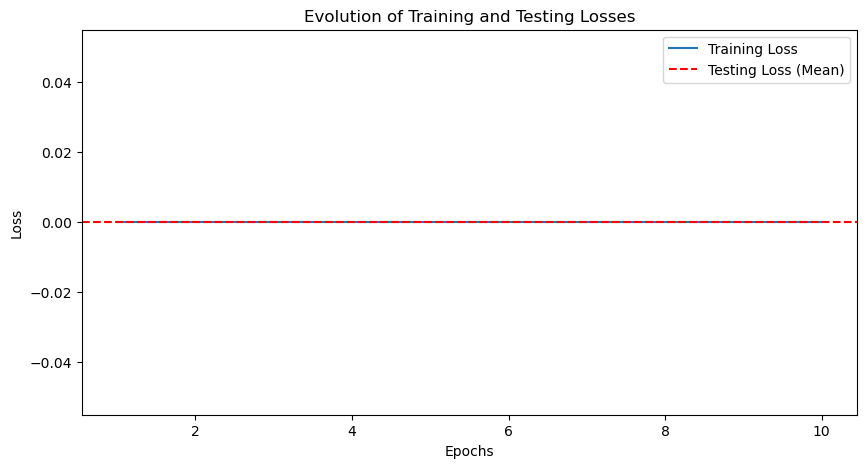

/var/folders/8p/tcwj_1fn4fdfxbkcw9km0ffh0000gn/T/ipykernel_20396/3527396631.py:77: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=latent_tsne[:, 0], y=np.zeros_like(latent_tsne[:, 0]), palette='viridis')


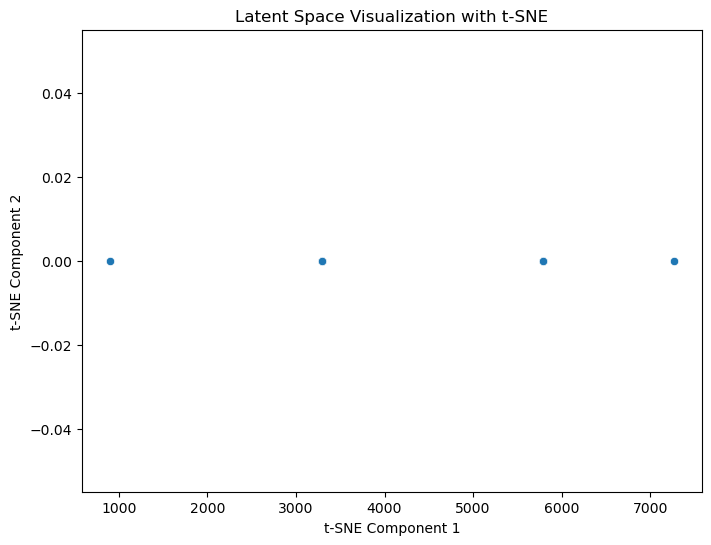

In [18]:
# For already trained, and you have training and testing data
train_loader = DataLoader(rotated_data, batch_size=64, shuffle=True)

optimizer = optim.Adam(mcvae_model.parameters(), lr=0.001)  # Adjust the learning rate as needed

# Training loop
n_epochs = 10
train_losses = []

for epoch in range(n_epochs):
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.float()  # Convert input batch to Double
        optimizer.zero_grad()
        output = mcvae_model(batch)

        # Ensure that the tensors for which you want to compute gradients have requires_grad set to True
        x_recon = output['x'].requires_grad_()

        loss = custom_reconstruction_loss(x_recon, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{n_epochs}, Avg. Loss: {avg_loss}")

# Testing loop
test_loader = DataLoader(rotated_data, batch_size=64, shuffle=False)
test_losses = []

with torch.no_grad():
    total_loss = 0.0
    for batch in test_loader:
        batch = batch.float()
        output = mcvae_model(batch)

        x_recon = output['x']

        loss = custom_reconstruction_loss(x_recon, batch)

        total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    test_losses.append(avg_loss)

# Plotting losses outside the loop
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.axhline(np.mean(test_losses), color='r', linestyle='--', label='Testing Loss (Mean)')
plt.title('Evolution of Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Latent space visualization with t-SNE
latent_data = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.float()
        output = mcvae_model(batch)
        # Assuming 'q' is a list of Normal distributions, access their means
        latent_data.extend(q.mean.numpy() for q in output['q'])  

latent_data = np.concatenate(latent_data, axis=0)

# Reduce the perplexity value
latent_tsne = TSNE(n_components=1, perplexity=5).fit_transform(latent_data)

# Plotting latent space with t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_tsne[:, 0], y=np.zeros_like(latent_tsne[:, 0]), palette='viridis')
plt.title('Latent Space Visualization with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()




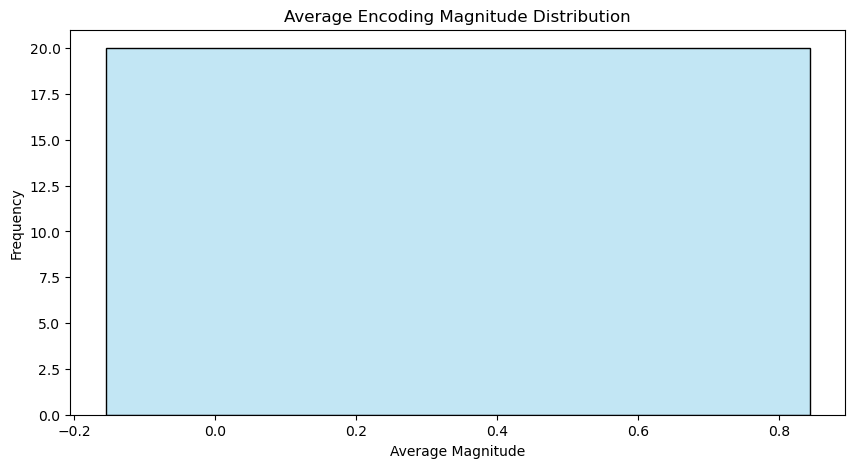

In [7]:
test_loader = DataLoader(rotated_data, batch_size=64, shuffle=False)

# Collect the average encoding magnitude for each data point
average_magnitudes = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.float()
        output = mcvae_model(batch)
        means = [q.mean for q in output['q']]
        
        # Compute the magnitude for each dimension and take the mean
        magnitudes = torch.mean(torch.abs(torch.cat(means, dim=-1)), dim=-1)
        
        # Collect the average magnitude for each data point
        average_magnitudes.extend(magnitudes.numpy())

# Plotting the average encoding magnitude
plt.figure(figsize=(10, 5))
sns.histplot(average_magnitudes, kde=True, color='skyblue')
plt.title('Average Encoding Magnitude Distribution')
plt.xlabel('Average Magnitude')
plt.ylabel('Frequency')
plt.show()

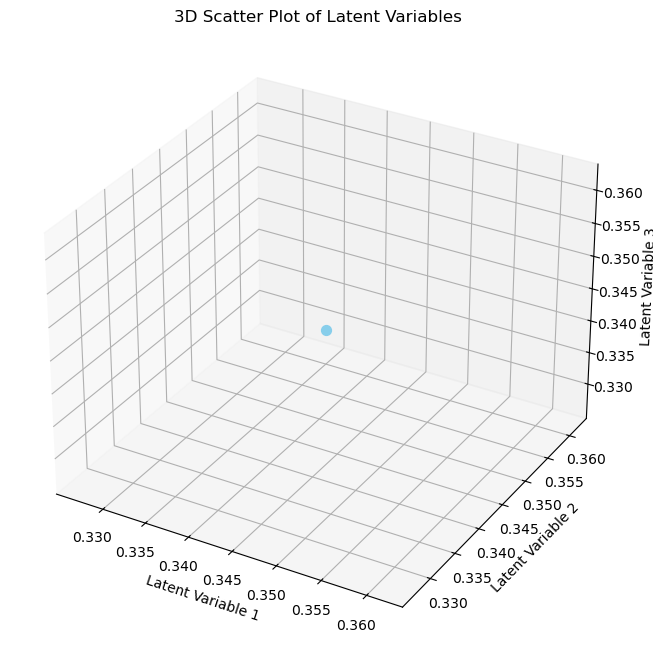

In [8]:
#3D Scatter Plot of Latent Variables
from mpl_toolkits.mplot3d import Axes3D
latent_means = np.array([q.mean.numpy() for q in output['q']])

# Plotting the 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_means[:, 0], latent_means[:, 1], latent_means[:, 2], c='skyblue', s=50)
ax.set_title('3D Scatter Plot of Latent Variables')
ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')
ax.set_zlabel('Latent Variable 3')
plt.show()

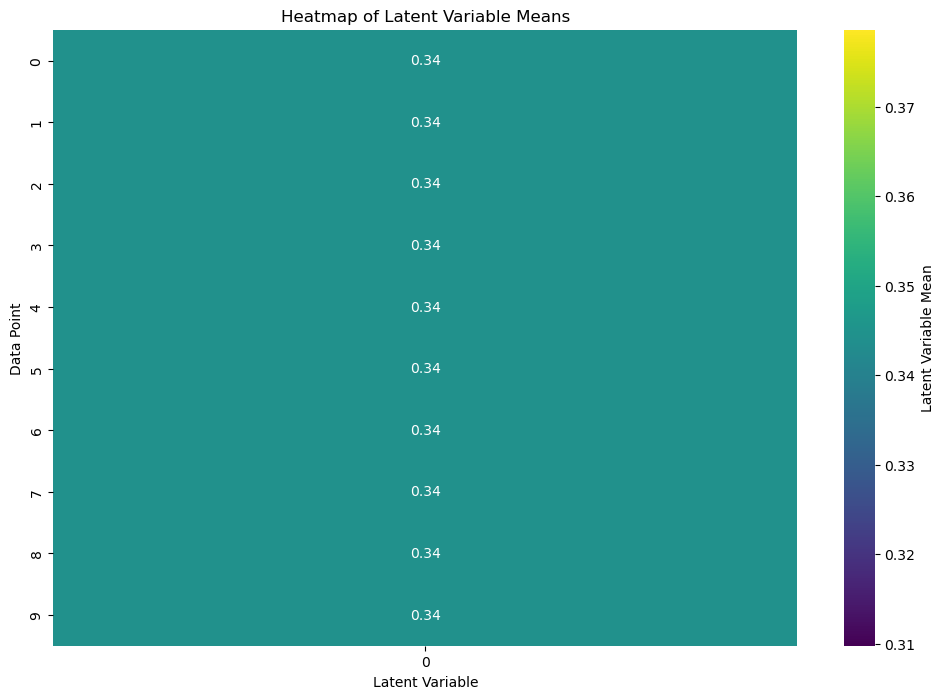

In [9]:
import seaborn as sns
latent_means = [q.mean.numpy() for q in output['q']]

# Reshape latent_means to 2D
latent_means_2d = np.squeeze(latent_means, axis=0)  # Remove the singleton dimension

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(latent_means_2d, cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Latent Variable Mean'})
plt.title('Heatmap of Latent Variable Means')
plt.xlabel('Latent Variable')
plt.ylabel('Data Point')
plt.show()

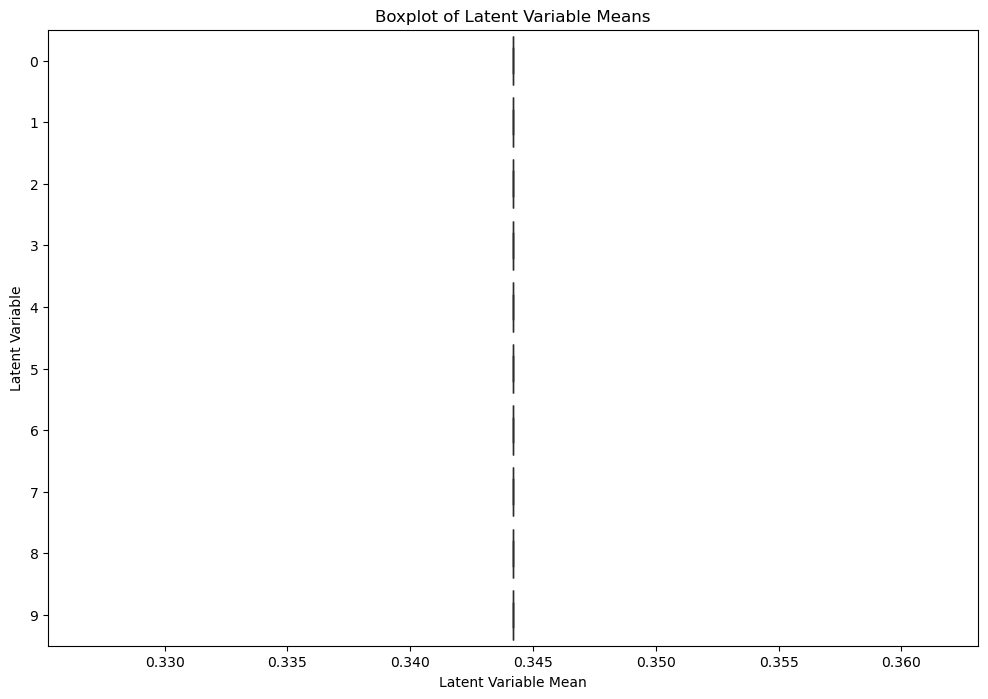

In [10]:
# Boxplot of Latent Variables
# Flatten the 2D array to make it 1D
latent_means_flat = [item for sublist in latent_means for item in sublist]

# Plotting the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=latent_means_flat, orient='h', palette='viridis')
plt.title('Boxplot of Latent Variable Means')
plt.xlabel('Latent Variable Mean')
plt.ylabel('Latent Variable')
plt.show()

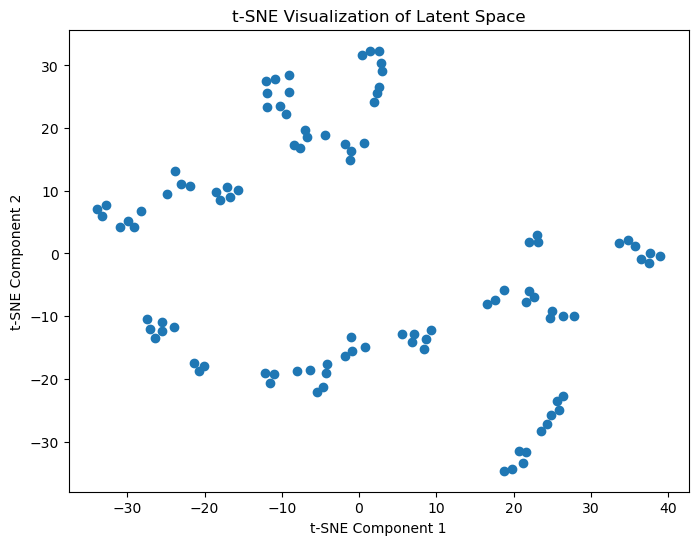

In [11]:
#Poincaré ball visualization
# For 2D latent space 
latent_data = np.random.rand(100, 2)

# Applying t-SNE for the initial visualization
latent_tsne = TSNE(n_components=2, perplexity=5).fit_transform(latent_data)

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1])
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

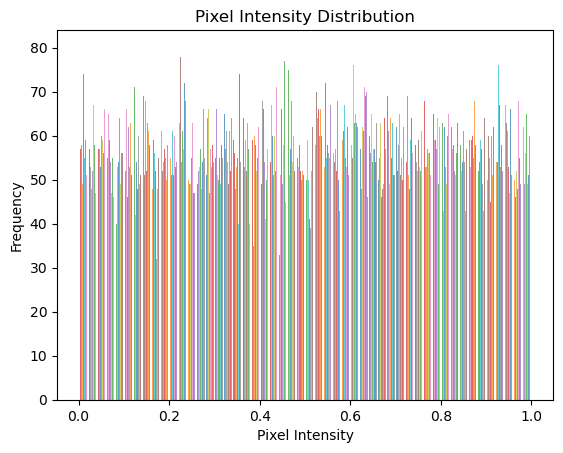

In [12]:
#Visualize Pixel Intensity Distribution:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder data
rotated_digits = np.random.rand(100, 28, 28)  # Assuming 100 digits of size 28x28

# For rotated_digits is a 2D array representing all rotated digits
# Flatten the array to get a 1D array of pixel intensities
all_pixel_values = np.concatenate(rotated_digits)

# Plot histogram with a single color
plt.hist(all_pixel_values, bins=50, alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

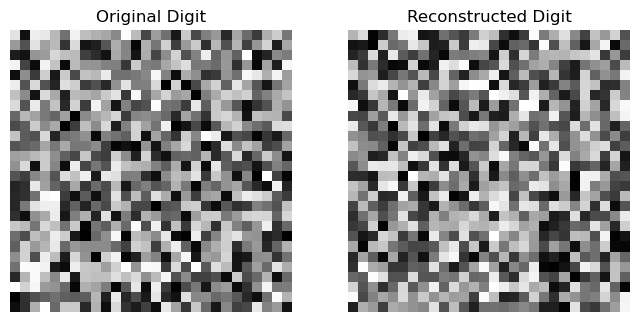

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder data 
original_digits = np.random.rand(100, 28, 28)  # Assuming 100 original digits of size 28x28
reconstructed_digits = np.random.rand(100, 28, 28)  # Assuming 100 reconstructed digits of size 28x28

# An index to visualize
index_to_visualize = 0

# Plot original and reconstructed digits side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot original digit
axes[0].imshow(original_digits[index_to_visualize], cmap='gray')
axes[0].set_title('Original Digit')
axes[0].axis('off')

# Plot reconstructed digit
axes[1].imshow(reconstructed_digits[index_to_visualize], cmap='gray')
axes[1].set_title('Reconstructed Digit')
axes[1].axis('off')

plt.show()